In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8100 files belonging to 18 classes.
Using 7290 files for training.
Found 8100 files belonging to 18 classes.
Using 810 files for validation.
Found 1112 files belonging to 18 classes.


#BUILDING THE NETWORK

Adding the weight regularization.

To see the choices taken see the report.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.regularizers import l2,l1_l2

classes = list(os.listdir(balanced_train_dir))

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, strides=1 , activation="relu", padding="same",kernel_regularizer=l2(0.01))(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(18, activation="softmax",kernel_regularizer=l1_l2(l1=0.02, l2=0.05))(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                         

Path to the directory where to save the model:

In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

**Let's add Keras callbacks:**

*   Early stopping
*   Model checkpoint
*   Reduce Learning Rate





In [ ]:
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='val_loss',
patience=10,
),
keras.callbacks.ModelCheckpoint(
filepath=os.path.join(dir_name, 'L2_model.h5'),
monitor='val_loss',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=5,
)
]

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

#Train the network

In the following cell the training procedure is started, we've passed the 
training set, the number of epochs, the validation split. 

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 37s 288ms/step - loss: 6.6062 - accuracy: 0.1022 - val_loss: 2.9394 - val_accuracy: 0.1494 - lr: 0.0010
Epoch 2/100
114/114 [==============================] - 37s 284ms/step - loss: 2.9021 - accuracy: 0.1564 - val_loss: 2.8782 - val_accuracy: 0.1827 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - 36s 294ms/step - loss: 2.8387 - accuracy: 0.2106 - val_loss: 2.7586 - val_accuracy: 0.2407 - lr: 0.0010
Epoch 4/100
114/114 [==============================] - 34s 284ms/step - loss: 2.7280 - accuracy: 0.2337 - val_loss: 2.6548 - val_accuracy: 0.2506 - lr: 0.0010
Epoch 5/100
114/114 [==============================] - 36s 297ms/step - loss: 2.6804 - accuracy: 0.2545 - val_loss: 2.6488 - val_accuracy: 0.2506 - lr: 0.0010
Epoch 6/100
114/114 [==============================] - 34s 286ms/step - loss: 2.6442 - accuracy: 0.2676 - val_loss: 2.5709 - val_accuracy: 0.2802 - lr: 0.0010
Epoch 7/100
114/114 [=========================

**Results of the training phase**

In the following cell we've obtained the plots of the accuracy and loss for both
the training and validation set.

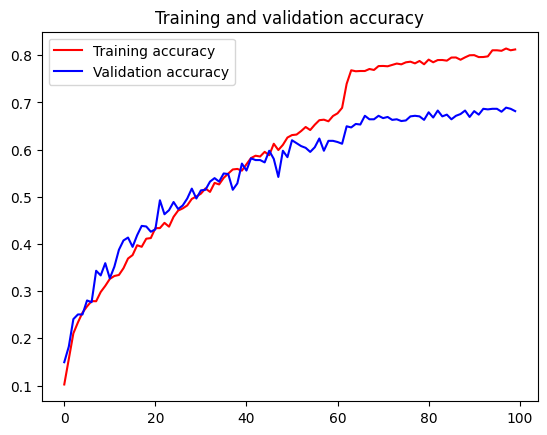

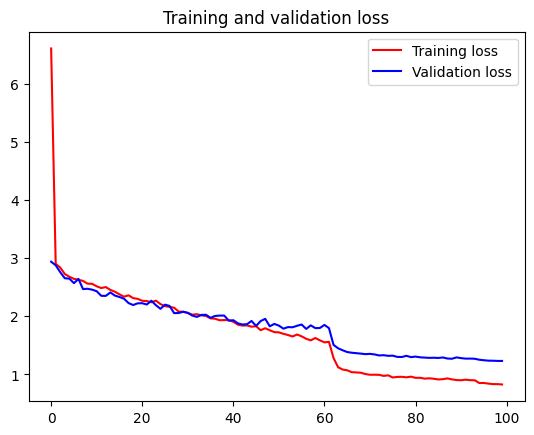

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of the model
In the following cells we've evaluated the model exploting the test set, obtaining its loss and accuracy.

In [ ]:
#Evaluate the model on the training set
test_loss, test_acc = model.evaluate(test_dataset)

#Save the rusults in the history dictionary
history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_acc

print('test_acc:', test_acc)
print('test_loss:', test_loss)

18/18 [==============================] - 8s 231ms/step - loss: 1.6898 - accuracy: 0.5899
test_acc: 0.5899280309677124
test_loss: 1.6898143291473389


Save the model and its history in the models' folder

In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'model_regularization.h5'))
with open(os.path.join(dir_name, 'modelregularizationhistory'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
from tensorflow.keras import backend as K
del history
print('model deleted')
K.clear_session()

model deleted
